<a href="https://colab.research.google.com/github/harnalashok/classification/blob/main/9_lead_scoirngAutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 20th July, 2021
# My folder: C:\Users\ashok\OneDrive\Documents\leads_scoring
#
# AutoML:
# Ref: https://evalml.alteryx.com/en/stable/demos/lead_scoring.html
# Lead scoring:
#      https://towardsdatascience.com/a-true-end-to-end-ml-example-lead-scoring-f5b52e9a3c80
# Kaggle 
#      https://www.kaggle.com/ashydv/leads-dataset

# Building a Lead Scoring Model with EvalML

In this example, we will build an optimized lead scoring model using [EvalML](https://github.com/alteryx/evalml). To optimize the pipeline, we will set up an objective function to maximize the revenue generated with true positives while taking into account the cost of false positives. At the end of this demo, we also show you how introducing the right objective during the training is significantly better than using a generic machine learning metric like AUC.

## Install packages

EvalML is an AutoML library that builds, optimizes, and evaluates machine learning pipelines using domain-specific objective functions.

Combined with Featuretools and Compose, EvalML can be used to create end-to-end supervised machine learning solutions.

In [ ]:
# Install evalml. Some of the packages installed are:
# imbalanced-learn, scikit-optimize, plotly, category-encoders,
# graphviz, lightgbm, shap, statsmodels, catboost, scikit-learn
# featuretools, matplotlib,nltk,xgboost, pmdarima (for the anagram of 'py' + 'arima')
# kaleido (blockchain) 

!pip install evalml
! pip install dask[dataframe] --upgrade 
! pip install ipywidgets

## Call libraries

In [19]:
# Call libraries
# 1.0 Data manipulation
import numpy as np
import pandas as pd

# 1.1 Auto Machine Learning
# conda install -c conda-forge evalml
import evalml
from evalml import AutoMLSearch
from evalml.objectives import LeadScoring
from evalml.model_understanding.graphs import graph_confusion_matrix, graph_roc_curve
from evalml.data_checks import DefaultDataChecks
# 1.2 URL open
from urllib.request import urlopen

# 1.3 Woodwork makes it easy to manage additional
#      'data-typing' information for your data,
#        and, therefore, access only the data one needs
#         based on these additional data-types, called
#          logical types or semantic tags.
#           It is used by featuretools and evalml

import woodwork as ww

# 1.4 Misc
import time

In [20]:
# 1.5
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


## Dataset

We will be utilizing a dataset detailing a customer’s job, country, state, zip, online action, the dollar amount of that action and whether they were a successful lead.

In [48]:
# Open URLs to access data
customers_data      = urlopen('https://featurelabs-static.s3.amazonaws.com/lead_scoring_ml_apps/customers.csv')
interactions_data   = urlopen('https://featurelabs-static.s3.amazonaws.com/lead_scoring_ml_apps/interactions.csv')
leads_data          = urlopen('https://featurelabs-static.s3.amazonaws.com/lead_scoring_ml_apps/previous_leads.csv')

# Method read() can be used to read data
##print(customers_data.read())

In [49]:
# Read lead-score tables from opened URL
customers = pd.read_csv(customers_data)
interactions = pd.read_csv(interactions_data)
leads = pd.read_csv(leads_data)

In [50]:
# Look at data
customers.shape    # (1000, 11)
customers.head()

(1000, 11)

,customer_id,date_registered,birthday,job,phone,email,country,state,zip,owner,company
0,460429349361,2017-08-10 11:04:45,NaN,"Engineer, mining",+1-283-990-1507x7713,christian92@gmail.com,NaN,NY,60091.0,Kathleen Hawkins MD,6.185414e+11
1,392559384176,2017-08-10 23:13:51,NaN,Arts administrator,400.808.2148,jenniferdavis@carter-ellis.biz,US,CA,NaN,John Edwards,8.330990e+11
2,674438580580,2017-08-11 08:35:32,NaN,"Psychologist, forensic",(299)543-9962,wwelch@lee.com,US,CA,NaN,John Edwards,2.114827e+11
3,364017777045,2017-08-11 10:15:37,NaN,Air cabin crew,+1-213-455-5314,xjones@smith.net,US,NaN,60091.0,Erica Anderson,NaN
4,551397602202,2017-08-11 13:33:23,NaN,Press sub,619.795.6618,walterromero@gmail.com,US,NaN,NaN,Kathleen Hawkins MD,NaN


In [51]:
#
interactions.shape  # (5625, 7)
interactions.head()

(5625, 7)

,id,time,customer_id,action,amount,session,referrer
0,807870369974,2017-08-17 18:18:45,676332384432,contact_form,NaN,531094009776,https://www.twitter.com
1,889936071815,2017-08-18 18:58:39,676332384432,contact_form,NaN,531094009776,https://www.twitter.com
2,890016715098,2017-08-22 15:54:26,756895858030,purchase,50.54,355429835992,NaN
3,539965059120,2017-08-24 23:25:33,676332384432,page_view,NaN,531094009776,NaN
4,496056352403,2017-08-25 09:32:25,676332384432,page_view,NaN,531094009776,https://medium.com/article


In [52]:
#
leads.shape  # (584, 3)
leads.head()

(584, 3)

,customer_id,time,label
0,961424493033,2017-09-17 08:20:09,False
1,739795366381,2017-09-20 18:14:56,False
2,433081973416,2017-09-26 12:14:42,False
3,178336564320,2017-09-29 12:48:25,False
4,203924762965,2017-10-02 02:57:06,False


In [53]:
customers.to_csv("customers.csv", index = False)
interactions.to_csv("interactions.csv", index = False)
leads.to_csv("leads.csv", index=False)

In [54]:
# Merge the three datasets
X = customers.merge(
                    interactions,
                    on='customer_id').merge(
                                            leads,
                                            on='customer_id'
                                            )
y = X['label']

In [ ]:
X.head()
y.head()

In [ ]:
X = X.drop(
            [ 'customer_id', 'date_registered', 'birthday','phone', 'email',
              'owner', 'company', 'id', 'time_x',
              'session', 'referrer', 'time_y', 'label', 'country'],
              axis=1
           )

display(X.head())

## Data Transformation
We will convert our data into Woodwork data structures. Doing so enables us to have more control over the types passed to and inferred by AutoML.

In [59]:
# Get default Woodwork data structure
# for this DataFrame by initializing it
#  with woordwork.init()

X.ww.init()

In [61]:
# Get X data type
# Semantic tag of 'jod; is not clear
X.ww

,Physical Type,Logical Type,Semantic Tag(s)
Column,,,
job,string,NaturalLanguage,[]
state,category,Categorical,['category']
zip,float64,Double,['numeric']
action,category,Categorical,['category']
amount,float64,Double,['numeric']


In [47]:
 #from evalml.utils import infer_feature_types
 #X = infer_feature_types(X)
 #type(X)

pandas.core.frame.DataFrame

In [62]:
# Initialize X with proper semantic tag
# for job
X.ww.init(
          semantic_tags={'job': 'category'},
          logical_types={'job': 'Categorical'}
          )

y = ww.init_series(y)
X.ww

,Physical Type,Logical Type,Semantic Tag(s)
Column,,,
job,category,Categorical,['category']
state,category,Categorical,['category']
zip,float64,Double,['numeric']
action,category,Categorical,['category']
amount,float64,Double,['numeric']


In [67]:
X.head(3)
type(X)
print()
type(y)
y[:4]

,job,state,zip,action,amount
0,"Engineer, mining",NY,60091.0,page_view,NaN
1,"Psychologist, forensic",CA,NaN,purchase,135.23
2,"Psychologist, forensic",CA,NaN,page_view,NaN


pandas.core.frame.DataFrame

pandas.core.series.Series

0    False
1     True
2     True
3    False
Name: label, dtype: bool

## Search for the best pipeline¶

In order to validate the results of the pipeline creation and optimization process, we will save some of our data as a holdout set.

EvalML natively supports one-hot encoding and imputation so the above NaN and categorical values will be taken care of.

In [72]:
X_train, X_holdout, y_train, y_holdout = evalml. \
                                         preprocessing. \
                                         split_data(
                                                     X, y,
                                                     problem_type='binary',
                                                     test_size=0.2,
                                                     random_seed=0
                                                    )


### Data Checks

Before calling AutoMLSearch.search, we should run some sanity checks on our data to ensure that the input data being passed will not run into some common issues before running a potentially time-consuming search. EvalML has various data checks that makes this easy. Each data check will return a collection of warnings and errors if it detects potential issues with the input data. This allows users to inspect their data to avoid confusing errors that may arise during the search process. You can learn about each of the data checks available through our data checks guide

Here, we will run the DefaultDataChecks class, which contains a series of data checks that are generally useful.

In [71]:
data_checks = DefaultDataChecks("binary", "log loss binary")
data_checks.validate(X_train, y_train)

{'actions': [],
 'errors': [],
 'warnings': [{'code': 'CLASS_IMBALANCE_BELOW_THRESHOLD',
   'data_check_name': 'ClassImbalanceDataCheck',
   'details': {'target_values': [True]},
   'level': 'warning',
   'message': 'The following labels fall below 10% of the target: [True]'}]}

## Configure LeadScoring objectives

In EvalML, you can have generic objectives, such as RMSE, loglossbinary or loglossmulticlass and so on. OR, you can have business specific objectives.
To optimize the pipelines toward the specific business needs of this model, you can set your own assumptions for how much value is gained through true positives and the cost associated with false positives. These parameters are

> true_positive - dollar amount to be gained with a successful lead  
false_positive - dollar amount to be lost with an unsuccessful lead

Using these parameters, EvalML builds a pileline that will maximize the amount of revenue per lead generated.

Because the lead scoring labels are binary, we will use `AutoMLSearch(X_train=X_train, y_train=y_train, problem_type='binary')`. When we call `.search()`, the search for the best pipeline will begin.

In [81]:
# Instantiate AutoMLSearch class 
automl = AutoMLSearch(
                      X_train=X_train,
                      y_train=y_train,
                      problem_type='binary',
                      objective=lead_scoring_objective, # Could be LogLossBinary 
                      additional_objectives=['auc'],
                      max_batches=3,
                      # allowed_model_families=["catboost", "random_forest", "linear_model"],
                    )



Generating pipelines to search over...
8 pipelines ready for search.


In [82]:
start = time.time()
automl.search()
end = time.time()
print("Time taken: ", (end-start)/60)


*****************************
* Beginning pipeline search *
*****************************

Optimizing for Lead Scoring. 
Greater score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 3 batches for a total of 19 pipelines. 
Allowed model families: lightgbm, linear_model, extra_trees, catboost, decision_tree, xgboost, random_forest



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Evaluating Baseline Pipeline: Mode Baseline Binary Classification Pipeline
Mode Baseline Binary Classification Pipeline:
	Starting cross validation
	Finished cross validation - mean Lead Scoring: 0.000

*****************************
* Evaluating Batch Number 1 *
*****************************

Elastic Net Classifier w/ Imputer + One Hot Encoder + SMOTENC Oversampler + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean Lead Scoring: 0.209
	High coefficient of variation (cv >= 0.2) within cross validation scores.
	Elastic Net Classifier w/ Imputer + One Hot Encoder + SMOTENC Oversampler + Standard Scaler may not perform as estimated on unseen data.
Decision Tree Classifier w/ Imputer + One Hot Encoder + SMOTENC Oversampler:
	Starting cross validation
	Finished cross validation - mean Lead Scoring: -0.006
	High coefficient of variation (cv >= 0.2) within cross validation scores.
	Decision Tree Classifier w/ Imputer + One Hot Encoder + SMOTENC Oversampler may not 

## View rankings and select pipeline

Once the fitting process is done, we can see all of the pipelines that were searched, ranked by their score on the lead scoring objective we defined.

In [83]:
automl.rankings

,id,pipeline_name,search_order,mean_cv_score,standard_deviation_cv_score,validation_score,percent_better_than_baseline,high_variance_cv,parameters
0,8,CatBoost Classifier w/ Imputer + SMOTENC Overs...,8,9.321308,8.073085,0.000000,inf,True,{'Imputer': {'categorical_impute_strategy': 'm...
1,6,XGBoost Classifier w/ Imputer + One Hot Encode...,6,1.008740,1.298148,-0.064516,inf,True,{'Imputer': {'categorical_impute_strategy': 'm...
6,7,Extra Trees Classifier w/ Imputer + One Hot En...,7,0.210890,0.370874,-0.006452,inf,True,{'Imputer': {'categorical_impute_strategy': 'm...
7,3,Random Forest Classifier w/ Imputer + One Hot ...,3,0.210890,0.370874,-0.006452,inf,True,{'Imputer': {'categorical_impute_strategy': 'm...
8,5,Logistic Regression Classifier w/ Imputer + On...,5,0.208740,0.372778,-0.012903,inf,True,{'Imputer': {'categorical_impute_strategy': 'm...
9,1,Elastic Net Classifier w/ Imputer + One Hot En...,1,0.208740,0.372778,-0.012903,inf,True,{'Imputer': {'categorical_impute_strategy': 'm...
13,4,LightGBM Classifier w/ Imputer + One Hot Encod...,4,0.180781,0.391822,-0.064516,inf,True,{'Imputer': {'categorical_impute_strategy': 'm...
16,0,Mode Baseline Binary Classification Pipeline,0,0.000000,0.000000,0.000000,0.0,False,{'Baseline Classifier': {'strategy': 'mode'}}
17,2,Decision Tree Classifier w/ Imputer + One Hot ...,2,-0.006452,0.011175,-0.019355,inf,True,{'Imputer': {'categorical_impute_strategy': 'm...


## Best pipeline

To select the best pipeline we can call automl.best_pipeline.

In [84]:
best_pipeline = automl.best_pipeline
print(best_pipeline)

CatBoost Classifier w/ Imputer + SMOTENC Oversampler


You can get more details about any pipeline, including how it performed on other objective functions by calling `.describe_pipeline()` and specifying the id of the pipeline.

In [79]:
automl.describe_pipeline(automl.rankings.iloc[0]["id"])


**********************************
* CatBoost Classifier w/ Imputer *
**********************************

Problem Type: binary
Model Family: CatBoost

Pipeline Steps
1. Imputer
	 * categorical_impute_strategy : most_frequent
	 * numeric_impute_strategy : mean
	 * categorical_fill_value : None
	 * numeric_fill_value : None
2. CatBoost Classifier
	 * n_estimators : 10
	 * eta : 0.03
	 * max_depth : 6
	 * bootstrap_type : None
	 * silent : True
	 * allow_writing_files : False
	 * n_jobs : -1

Training
Training for binary problems.
Objective to optimize binary classification pipeline thresholds for: <evalml.objectives.lead_scoring.LeadScoring object at 0x7fa51fc20e50>
Total training time (including CV): 0.9 seconds

Cross Validation
----------------
             Lead Scoring   AUC # Training # Validation
0                   0.000 0.600      3,099        1,550
1                   5.110 0.509      3,099        1,550
2                   0.000 0.576      3,100        1,549
mean               

## Evaluate on hold out data

Finally, since the best pipeline was trained on all of the training data, we evaluate it on the holdout dataset.

In [85]:
best_pipeline.score(
                     X_holdout,
                     y_holdout,
                     objectives=["auc", lead_scoring_objective])

OrderedDict([('AUC', 0.8585599879117558), ('Lead Scoring', 14.7463456577816)])

## Why optimize for a problem-specific objective?

To demonstrate the importance of optimizing for the right objective, let’s search for another pipeline using AUC, a common machine learning metric. After that, we will score the holdout data using the lead scoring objective to see how the best pipelines compare.

In [86]:
# Instantiate AutoMLSearch class
automl_auc = evalml.AutoMLSearch(
                                 X_train=X_train,
                                 y_train=y_train,
                                 problem_type='binary',
                                 objective='auc',
                                 additional_objectives=[],
                                 max_batches=3,
                                 optimize_thresholds=True,
                                 sampler_method=None)

# Execute search()
automl_auc.search()

Generating pipelines to search over...
8 pipelines ready for search.

*****************************
* Beginning pipeline search *
*****************************

Optimizing for AUC. 
Greater score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 3 batches for a total of 19 pipelines. 
Allowed model families: lightgbm, linear_model, extra_trees, catboost, decision_tree, xgboost, random_forest



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Evaluating Baseline Pipeline: Mode Baseline Binary Classification Pipeline
Mode Baseline Binary Classification Pipeline:
	Starting cross validation
	Finished cross validation - mean AUC: 0.500

*****************************
* Evaluating Batch Number 1 *
*****************************

Elastic Net Classifier w/ Imputer + One Hot Encoder + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean AUC: 0.680
Decision Tree Classifier w/ Imputer + One Hot Encoder:
	Starting cross validation
	Finished cross validation - mean AUC: 0.611
Random Forest Classifier w/ Imputer + One Hot Encoder:
	Starting cross validation
	Finished cross validation - mean AUC: 0.669
LightGBM Classifier w/ Imputer + One Hot Encoder:
	Starting cross validation
	Finished cross validation - mean AUC: 0.655
Logistic Regression Classifier w/ Imputer + One Hot Encoder + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean AUC: 0.679
XGBoost Classifier w/ Imputer + One Hot Encod

In [ ]:
automl_auc.rankings

Like before, we can look at the rankings and pick the best pipeline.

In [88]:
best_pipeline_auc = automl_auc.best_pipeline

In [89]:
# get the auc and lead scoring score on holdout data
best_pipeline_auc.score(
                        X_holdout,
                        y_holdout,
                        objectives=[
                                     "auc",
                                     lead_scoring_objective
                                    ]
                        )

OrderedDict([('AUC', 0.6630628588697491),
             ('Lead Scoring', -0.04299226139294927)])

When we optimize for AUC, we can see that the AUC score from this pipeline is better than the AUC score from the pipeline optimized for lead scoring. However, the revenue per lead is much smaller per lead when optimized for AUC and was much larger when optimized for lead scoring. As a result, we would have a huge gain on the amount of revenue if we optimized for lead scoring.

This happens because optimizing for AUC does not take into account the user-specified true_positive (dollar amount to be gained with a successful lead) and false_positive (dollar amount to be lost with an unsuccessful lead) values. Thus, the best pipelines may produce the highest AUC but may not actually generate the most revenue through lead scoring.

This example highlights how performance in the real world can diverge greatly from machine learning metrics.

## Further evaluation

In [90]:
best_pipeline_auc.graph_feature_importance()

### Which features have been engineered

In [91]:
best_pipeline_auc.input_feature_names

{'Extra Trees Classifier': ['zip',
  'amount',
  'job_Bookseller',
  'job_Chartered management accountant',
  'job_Clothing/textile technologist',
  'job_Designer, television/film set',
  'job_Development worker, community',
  'job_Insurance claims handler',
  'job_Medical illustrator',
  'job_Scientist, biomedical',
  'job_Scientist, forensic',
  'job_Television/film/video producer',
  'state_CA',
  'state_FL',
  'state_IL',
  'state_MA',
  'state_NY',
  'action_contact_form',
  'action_download',
  'action_page_view',
  'action_purchase'],
 'Imputer': ['job', 'state', 'zip', 'action', 'amount'],
 'One Hot Encoder': ['job', 'state', 'zip', 'action', 'amount']}

### Our pipeline flow

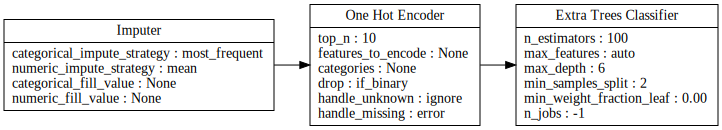

In [92]:
#visualizing best pipeline flow 
best_pipeline_auc.graph()

### Save model for subsequent use

In [93]:
best_pipeline.save("model.pkl")

In [94]:
check_model=automl.load('model.pkl')

In [95]:
check_model.predict_proba(X_holdout).to_dataframe()

AttributeError: ignored

### ROC graph and Confusion matrix

In [96]:
# pipeline trained with log loss
y_pred = best_pipeline_auc.predict(X_holdout)
graph_confusion_matrix(y_holdout, y_pred)



In [97]:
y_pred = best_pipeline_auc.predict_proba(X_holdout)
graph_roc_curve(y_holdout, y_pred)

In [ ]:
########## I am done ##############